<a href="https://colab.research.google.com/github/tutsilianna/generating_text_using_ruGPT3/blob/main/lstm/LSTM_%D0%BD%D0%B5%D0%B8%CC%86%D1%80%D0%BE%D0%BD%D0%BD%D1%8B%D0%B5_%D1%81%D0%B5%D1%82%D0%B8_2_%D1%8D%D1%82%D0%B0%D0%BF_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Подключение репозитория

In [1]:
! git clone https://github.com/tutsilianna/generating_text_using_ruGPT3.git

Cloning into 'generating_text_using_ruGPT3'...
remote: Enumerating objects: 16, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 16 (delta 2), reused 10 (delta 1), pack-reused 0 (from 0)
Receiving objects: 100% (16/16), 1.79 MiB | 3.83 MiB/s, done.
Resolving deltas: 100% (2/2), done.


### Необходимые библиотеки

In [2]:
import os
import re
import string

import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm

import warnings
import numpy as np
import pandas as pd


warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
from transformers import GPT2Tokenizer
from tokenizers import ByteLevelBPETokenizer
import matplotlib.pyplot as plt
from google.colab import drive

In [4]:
# First check to see if you have GPU or not
torch.cuda.is_available()

True

### Чтение данных

In [5]:
with open("/content/generating_text_using_ruGPT3/data/greetings.txt", "r", encoding="utf-8") as file:
    lines = file.readlines()

# Убираем символы новой строки из каждой строки
texts = [line.strip() for line in lines]

texts[:5]

['Красота - моя кума: Всем мне - очень хороша! И добра, мила, приятна, Мне с тобою так отрадно!  С Днём рождения, родня! Ты - подруга для меня: Ты с отзывчивой душою, Будь всегда, кума, такою!  Будь здорова, весела!! Денежек тебе сполна: Чтоб хватало на все блага! Чтоб жила в красе, без страха!',
 'Девятнадцатый сегодня день рожденья, Пожелать тебе хочу я в праздник твой, Будет крепким у тебя твое терпенье, И всегда удача мчится за тобой.  От души тебя, Родной мой, поздравляю, Целей всех тебе желаю достигать, И счастливым самым быть тебе желаю, И тебе любовь всем сердцем ощущать.',
 'Счастья, радости, здоровья И богатства непременно, Пусть все то, о чем мечтаешь Исполняется мгновенно. Денег много получать, Чтобы тратить – не считать! Верь, что сбудется она, Твоя главная мечта!',
 'Я очень благодарна папе, За то, что выбрал он тебя. Ты бесподобная хозяйка И безупречная жена. А для меня, родная мама, Ты осветишь любую ночь. Пока ты есть – не надо рая. Люблю! Целую! Твоя дочь!',
 'Тебя я 

### Предобработка

In [6]:
def clean_text(input_text):
    text = "".join(word for word in input_text if word not in string.punctuation).lower()
    text = re.sub(r"[^а-яё\s0-9]", "", text)
    return text

texts_join = ' '.join([clean_text(text) for text in texts])
texts_join[:1000]

'красота  моя кума всем мне  очень хороша и добра мила приятна мне с тобою так отрадно  с днём рождения родня ты  подруга для меня ты с отзывчивой душою будь всегда кума такою  будь здорова весела денежек тебе сполна чтоб хватало на все блага чтоб жила в красе без страха девятнадцатый сегодня день рожденья пожелать тебе хочу я в праздник твой будет крепким у тебя твое терпенье и всегда удача мчится за тобой  от души тебя родной мой поздравляю целей всех тебе желаю достигать и счастливым самым быть тебе желаю и тебе любовь всем сердцем ощущать счастья радости здоровья и богатства непременно пусть все то о чем мечтаешь исполняется мгновенно денег много получать чтобы тратить  не считать верь что сбудется она твоя главная мечта я очень благодарна папе за то что выбрал он тебя ты бесподобная хозяйка и безупречная жена а для меня родная мама ты осветишь любую ночь пока ты есть  не надо рая люблю целую твоя дочь тебя я поздравляю мой сынок тебе счастливой жизни я желаю на сердце пусть не буд

### `Character-Level ::: модель`

#### Tokenizer

In [7]:
chars = tuple(set(texts_join))
# print(chars)
print(f'{len(chars)=}')
int2char = dict(enumerate(chars))
# print(int2char)
char2int = {ch: ii for ii, ch in int2char.items()}
encoded = np.array([char2int[ch] for ch in texts_join])
print(f'{len(encoded)=}')

len(chars)=44
len(encoded)=2643268


In [8]:
encoded[:100]

array([10, 12,  1,  6, 25, 16,  1,  7,  7,  2, 25, 29,  7, 10, 18,  2,  1,
        7, 34,  6, 30,  2,  7,  2, 36, 30,  7,  7, 25, 20, 30, 36,  5,  7,
       31, 25, 12, 25, 35,  1,  7, 41,  7, 38, 25, 11, 12,  1,  7,  2, 41,
       13,  1,  7, 23, 12, 41, 29, 16, 36,  1,  7,  2, 36, 30,  7,  6,  7,
       16, 25, 11, 25, 14,  7, 16,  1, 10,  7, 25, 16, 12,  1, 38, 36, 25,
        7,  7,  6,  7, 38, 36, 37,  2,  7, 12, 25, 32, 38, 30, 36])

#### Pre-processing the data

In [9]:
def one_hot_encode(arr, n_labels):
    one_hot = np.zeros((np.multiply(*arr.shape), n_labels), dtype=np.float32)
    one_hot[np.arange(one_hot.shape[0]), arr.flatten()] = 1.
    one_hot = one_hot.reshape((*arr.shape, n_labels))

    return one_hot

In [10]:
def get_batches(arr, n_seqs, n_steps):
    '''Create a generator that returns batches of size
       n_seqs x n_steps from arr.

       Arguments
       ---------
       arr: Array you want to make batches from
       n_seqs: Batch size, the number of sequences per batch
       n_steps: Number of sequence steps per batch
    '''

    batch_size = n_seqs * n_steps
    n_batches = len(arr)//batch_size
    arr = arr[:int(n_batches*batch_size)]

    arr = np.reshape(arr, (n_seqs,-1))

    for n in range(0, arr.shape[1], n_steps):
        x = arr[:,n:n+n_steps]
        y = np.zeros_like(x)
        try:
            y[:, :-1], y[:, -1] = x[:, 1:], arr[:, n+n_steps]
        except IndexError:
            y[:, :-1], y[:, -1] = x[:, 1:], arr[:, 0]

        yield x, y

In [12]:
class CharLSTM(nn.Module):

    def __init__(self, tokens, n_steps=100, n_hidden=256, n_layers=2,
                               drop_prob=0.5, lr=0.001):
        super().__init__()
        self.drop_prob = drop_prob
        self.n_layers = n_layers
        self.n_hidden = n_hidden
        self.lr = lr

        self.chars = tokens
        self.int2char = dict(enumerate(self.chars))
        self.char2int = {ch: ii for ii, ch in self.int2char.items()}

        # define the LSTM, self.lstm
        self.lstm = nn.LSTM(len(self.chars), n_hidden, n_layers, dropout=drop_prob, batch_first=True)
        # input is a one_hot vector over the unique 83 characters (len(chars))

        # define a dropout layer, self.dropout
        self.dropout = nn.Dropout(drop_prob)

        # define the final, fully-connected output layer, self.fc
        self.fc = nn.Linear(n_hidden, len(self.chars))

        # initialize the weights
        self.init_weights()

    def forward(self, x, hc):
        ''' Forward pass through the network.
            These inputs are x, and the hidden/cell state `hc`. '''

        # Get x, and the new hidden state (h, c) from the lstm
        lstm_out, (h, c) = self.lstm(x, hc)

        # stack up LSTM outputs
        x = lstm_out.contiguous()

        # pass x through a droupout layer
        x = self.dropout(x)

        # Stack up LSTM outputs using view
        x = x.view(-1, self.n_hidden)

        # put x through the fully-connected layer
        x = self.fc(x)

        # return x and the hidden state (h, c)
        return x, (h, c)

    def predict(self, char, h=None, cuda=False, top_k=None):
        ''' Given a character, predict the next character.

            Returns the predicted character and the hidden state.
        '''
        if cuda:
            self.cuda()
        else:
            self.cpu()

        if h is None:
            h = self.init_hidden(1)

        x = np.array([[self.char2int[char]]])
        x = one_hot_encode(x, len(self.chars))
        inputs = torch.from_numpy(x)
        if cuda:
            inputs = inputs.cuda()

        h = tuple([each.data for each in h])
        out, h = self.forward(inputs, h)

        p = F.softmax(out, dim=1).data
        if cuda:
            p = p.cpu()

        if top_k is None:
            top_ch = np.arange(len(self.chars))
        else:
            p, top_ch = p.topk(top_k)
            top_ch = top_ch.numpy().squeeze()

        p = p.numpy().squeeze()
        char = np.random.choice(top_ch, p=p/p.sum())

        return self.int2char[char], h

    def init_weights(self):
        ''' Initialize weights for fully connected layer '''
        initrange = 0.1

        # Set bias tensor to all zeros
        self.fc.bias.data.fill_(0)
        # FC weights as random uniform
        self.fc.weight.data.uniform_(-1, 1)

    def init_hidden(self, n_seqs):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x n_seqs x n_hidden,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data
        return (weight.new(self.n_layers, n_seqs, self.n_hidden).zero_(),
                weight.new(self.n_layers, n_seqs, self.n_hidden).zero_())

In [ ]:
# import os
# import requests
# import time

# def train(net, data, epochs=10, n_seqs=10, n_steps=50, lr=0.001, clip=5, val_frac=0.1, cuda=False, print_every=10):
#     ''' Training a network

#         Arguments
#         ---------

#         net: CharRNN network
#         data: text data to train the network
#         epochs: Number of epochs to train
#         n_seqs: Number of mini-sequences per mini-batch, aka batch size
#         n_steps: Number of character steps per mini-batch
#         lr: learning rate
#         clip: gradient clipping
#         val_frac: Fraction of data to hold out for validation
#         cuda: Train with CUDA on a GPU
#         print_every: Number of steps for printing training and validation loss

#     '''

#     net.train()
#     opt = torch.optim.Adam(net.parameters(), lr=lr)
#     criterion = nn.CrossEntropyLoss()

#     # create training and validation data
#     val_idx = int(len(data)*(1-val_frac))
#     data, val_data = data[:val_idx], data[val_idx:]

#     if cuda:
#         net.cuda()

#     counter = 0
#     n_chars = len(net.chars)

#     old_time = time.time()

#     for e in range(epochs):
#         h = net.init_hidden(n_seqs)
#         for x, y in get_batches(data, n_seqs, n_steps):

#             # if time.time() - old_time > 60:
#             #     old_time = time.time()
#             #     requests.request("POST",
#             #                      "https://nebula.udacity.com/api/v1/remote/keep-alive",
#             #                      headers={'Authorization': "STAR " + response.text})

#             counter += 1

#             # One-hot encode our data and make them Torch tensors
#             x = one_hot_encode(x, n_chars)
#             inputs, targets = torch.from_numpy(x), torch.from_numpy(y)

#             if cuda:
#                 inputs, targets = inputs.cuda(), targets.cuda()

#             # Creating new variables for the hidden state, otherwise
#             # we'd backprop through the entire training history
#             h = tuple([each.data for each in h])

#             net.zero_grad()

#             output, h = net.forward(inputs, h)

#             loss = criterion(output, targets.view(n_seqs*n_steps))

#             loss.backward()

#             # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
#             nn.utils.clip_grad_norm_(net.parameters(), clip)

#             opt.step()

#             if counter % print_every == 0:
#                 # Get validation loss
#                 val_h = net.init_hidden(n_seqs)
#                 val_losses = []
#                 for x, y in get_batches(val_data, n_seqs, n_steps):
#                     # One-hot encode our data and make them Torch tensors
#                     x = one_hot_encode(x, n_chars)
#                     x, y = torch.from_numpy(x), torch.from_numpy(y)

#                     # Creating new variables for the hidden state, otherwise
#                     # we'd backprop through the entire training history
#                     val_h = tuple([each.data for each in val_h])

#                     inputs, targets = x, y

#                     if cuda:
#                         inputs, targets = inputs.cuda(), targets.cuda()

#                     output, val_h = net.forward(inputs, val_h)

#                     val_loss = criterion(output, targets.view(n_seqs*n_steps))

#                     val_losses.append(val_loss.item())

#                 print("Epoch: {}/{}...".format(e+1, epochs),
#                       "Step: {}...".format(counter),
#                       "Loss: {:.4f}...".format(loss.item()),
#                       "Val Loss: {:.4f}".format(np.mean(val_losses)))

In [ ]:
# def train(net, data, epochs=10, n_seqs=10, n_steps=50, lr=0.001, clip=5,
#           val_frac=0.1, cuda=False, print_every=10):

#     net.train()
#     opt = torch.optim.Adam(net.parameters(), lr=lr)
#     criterion = nn.CrossEntropyLoss()

#     # create training and validation data
#     val_idx = int(len(data)*(1-val_frac))
#     data, val_data = data[:val_idx], data[val_idx:]

#     if cuda:
#         net.cuda()

#     counter = 0
#     n_chars = len(net.chars)

#     # Списки для хранения значений лосс и перплексии
#     train_losses, val_losses, perplexities = [], [], []

#     for e in range(epochs):
#         h = net.init_hidden(n_seqs)
#         for x, y in get_batches(data, n_seqs, n_steps):

#             counter += 1

#             # One-hot encode our data and make them Torch tensors
#             x = one_hot_encode(x, n_chars)
#             inputs, targets = torch.from_numpy(x), torch.from_numpy(y)

#             if cuda:
#                 inputs, targets = inputs.cuda(), targets.cuda()

#             h = tuple([each.data for each in h])

#             net.zero_grad()

#             output, h = net.forward(inputs, h)

#             loss = criterion(output, targets.view(n_seqs*n_steps))

#             loss.backward()

#             nn.utils.clip_grad_norm_(net.parameters(), clip)

#             opt.step()

#             train_losses.append(loss.item())

#             if counter % print_every == 0:
#                 val_h = net.init_hidden(n_seqs)
#                 val_losses_temp = []
#                 for x, y in get_batches(val_data, n_seqs, n_steps):
#                     # One-hot encode our data and make them Torch tensors
#                     x = one_hot_encode(x, n_chars)
#                     x, y = torch.from_numpy(x), torch.from_numpy(y)

#                     # Creating new variables for the hidden state, otherwise
#                     # we'd backprop through the entire training history
#                     val_h = tuple([each.data for each in val_h])

#                     inputs, targets = x, y

#                     if cuda:
#                         inputs, targets = inputs.cuda(), targets.cuda()

#                     output, val_h = net.forward(inputs, val_h)

#                     val_loss = criterion(output, targets.view(n_seqs*n_steps))

#                     val_losses_temp.append(val_loss.item())

#                 mean_val_loss = np.mean(val_losses_temp)
#                 val_losses.append(mean_val_loss)

#                 # Вычисление перплексии
#                 perplexity = np.exp(mean_val_loss)
#                 perplexities.append(perplexity)

#                 print("Epoch: {}/{}...".format(e+1, epochs),
#                       "Step: {}...".format(counter),
#                       "Loss: {:.4f}...".format(loss.item()),
#                       "Val Loss: {:.4f}...".format(mean_val_loss),
#                       "Perplexity: {:.4f}".format(perplexity))

#     # Сохранение значений для графиков
#     return train_losses, val_losses, perplexities

In [13]:
import os

def save_checkpoint(model, optimizer, epoch, train_loss, val_loss, filepath):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_loss': train_loss,
        'val_loss': val_loss
    }
    torch.save(checkpoint, filepath)

def load_checkpoint(filepath, model, optimizer=None):
    checkpoint = torch.load(filepath)
    model.load_state_dict(checkpoint['model_state_dict'])
    if optimizer:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    return checkpoint['epoch'], checkpoint['train_loss'], checkpoint['val_loss']

In [15]:
def train(net, data, epochs=10, n_seqs=10, n_steps=50, lr=0.001, clip=5,
          val_frac=0.1, cuda=False, print_every=10, save_path="model_checkpoint.pth"):
    import matplotlib.pyplot as plt
    import os

    device = torch.device("cuda" if cuda and torch.cuda.is_available() else "cpu")
    net.to(device)

    opt = torch.optim.Adam(net.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    val_idx = int(len(data) * (1 - val_frac))
    train_data, val_data = data[:val_idx], data[val_idx:]

    train_losses, val_losses = [], []
    train_perplexities, val_perplexities = [], []

    try:
        for e in range(epochs):
            net.train()
            h = net.init_hidden(n_seqs)
            epoch_train_loss = 0
            num_batches = 0

            for x, y in get_batches(train_data, n_seqs, n_steps):
                num_batches += 1
                x = torch.from_numpy(one_hot_encode(x, len(net.chars))).to(device)
                y = torch.from_numpy(y).to(device)
                h = tuple([each.data for each in h])

                opt.zero_grad()
                output, h = net(x, h)
                loss = criterion(output, y.view(n_seqs * n_steps))
                loss.backward()

                nn.utils.clip_grad_norm_(net.parameters(), clip)
                opt.step()

                epoch_train_loss += loss.item()

            avg_train_loss = epoch_train_loss / num_batches
            train_losses.append(avg_train_loss)
            train_perplexities.append(np.exp(avg_train_loss))

            # Валидация
            net.eval()
            val_loss = 0
            num_val_batches = 0
            h = net.init_hidden(n_seqs)
            with torch.no_grad():
                for x, y in get_batches(val_data, n_seqs, n_steps):
                    num_val_batches += 1
                    x = torch.from_numpy(one_hot_encode(x, len(net.chars))).to(device)
                    y = torch.from_numpy(y).to(device)
                    h = tuple([each.data for each in h])
                    output, h = net(x, h)
                    loss = criterion(output, y.view(n_seqs * n_steps))
                    val_loss += loss.item()

            avg_val_loss = val_loss / num_val_batches
            val_losses.append(avg_val_loss)
            val_perplexities.append(np.exp(avg_val_loss))

            # Сохранение чекпоинта (перезапись файла)
            torch.save({
                'epoch': e + 1,
                'model_state_dict': net.state_dict(),
                'optimizer_state_dict': opt.state_dict(),
                'train_loss': avg_train_loss,
                'val_loss': avg_val_loss
            }, save_path)

            print(f"Epoch: {e + 1}/{epochs}... "
                  f"Train Loss: {avg_train_loss:.4f}... "
                  f"Val Loss: {avg_val_loss:.4f}... "
                  f"Train Perplexity: {train_perplexities[-1]:.4f}... "
                  f"Val Perplexity: {val_perplexities[-1]:.4f}")

    except KeyboardInterrupt:
        print("\nTraining interrupted. Saving model...")
        # Сохранение модели в случае прерывания
        torch.save({
            'epoch': e + 1,
            'model_state_dict': net.state_dict(),
            'optimizer_state_dict': opt.state_dict(),
            'train_loss': avg_train_loss,
            'val_loss': avg_val_loss
        }, save_path)
        print(f"Model saved to {save_path} after interruption.")

    # Построение графиков
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss over epochs")
    plt.legend()
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.plot(train_perplexities, label="Train Perplexity")
    plt.plot(val_perplexities, label="Validation Perplexity")
    plt.xlabel("Epochs")
    plt.ylabel("Perplexity")
    plt.title("Perplexity over epochs")
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

    return train_losses, val_losses, train_perplexities, val_perplexities

In [14]:
if 'net' in locals():
    del net

In [16]:
# define and print the net
net = CharLSTM(chars, n_hidden=1024, n_layers=3)
print(net)

CharLSTM(
  (lstm): LSTM(44, 1024, num_layers=3, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=1024, out_features=44, bias=True)
)


In [17]:
# check if GPU is available
train_on_gpu = torch.cuda.is_available()
if(train_on_gpu):
    print('Training on GPU!')
    cuda=True
else:
    print('No GPU available, training on CPU; consider making n_epochs very small.')
    cuda=False

Training on GPU!


Epoch: 1/25... Train Loss: 2.4014... Val Loss: 1.7381... Train Perplexity: 11.0389... Val Perplexity: 5.6868
Epoch: 2/25... Train Loss: 1.6831... Val Loss: 1.4217... Train Perplexity: 5.3821... Val Perplexity: 4.1443
Epoch: 3/25... Train Loss: 1.4552... Val Loss: 1.2787... Train Perplexity: 4.2855... Val Perplexity: 3.5919
Epoch: 4/25... Train Loss: 1.3358... Val Loss: 1.2013... Train Perplexity: 3.8029... Val Perplexity: 3.3243
Epoch: 5/25... Train Loss: 1.2651... Val Loss: 1.1536... Train Perplexity: 3.5434... Val Perplexity: 3.1695
Epoch: 6/25... Train Loss: 1.2184... Val Loss: 1.1195... Train Perplexity: 3.3819... Val Perplexity: 3.0633
Epoch: 7/25... Train Loss: 1.1816... Val Loss: 1.0970... Train Perplexity: 3.2597... Val Perplexity: 2.9951
Epoch: 8/25... Train Loss: 1.1528... Val Loss: 1.0801... Train Perplexity: 3.1672... Val Perplexity: 2.9451
Epoch: 9/25... Train Loss: 1.1296... Val Loss: 1.0690... Train Perplexity: 3.0944... Val Perplexity: 2.9124
Epoch: 10/25... Train Loss:

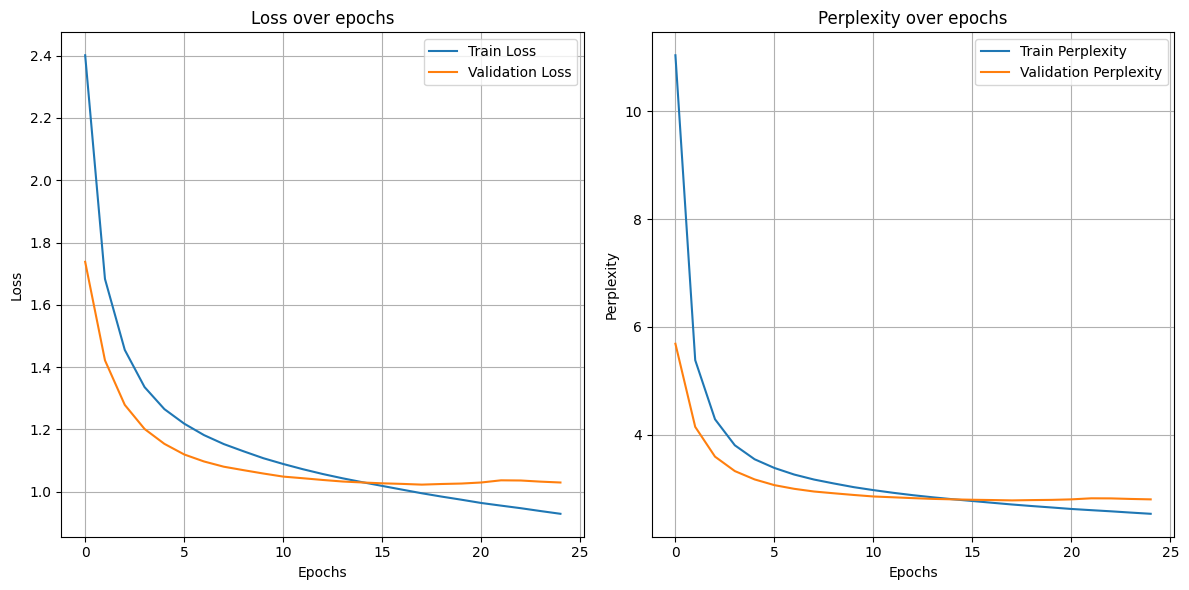

ValueError: too many values to unpack (expected 3)

In [18]:
n_seqs, n_steps = 128, 100
# TRAIN
# train(net, encoded, epochs=25, n_seqs=n_seqs, n_steps=n_steps, lr=0.001, cuda=cuda, print_every=10)

train_losses, val_losses, train_perplexities, val_perplexities = train(
    net, encoded, epochs=25,
    n_seqs=n_seqs, n_steps=n_steps,
    lr=0.001, cuda=cuda, print_every=10
)

In [21]:
# change the name, for saving multiple files
model_name = 'LSTM_25_epoch.net'

checkpoint = {'n_hidden': net.n_hidden,
              'n_layers': net.n_layers,
              'state_dict': net.state_dict(),
              'tokens': net.chars}

with open(model_name, 'wb') as f:
    torch.save(checkpoint, f)

In [22]:
def sample(net, size, prime='поздравляю тебя', top_k=None, cuda=False):

    if cuda:
        net.cuda()
    else:
        net.cpu()

    net.eval()

    # First off, run through the prime characters
    chars = [ch for ch in prime]
    h = net.init_hidden(1)
    for ch in prime:
        char, h = net.predict(ch, h, cuda=cuda, top_k=top_k)

    chars.append(char)

    # Now pass in the previous character and get a new one
    for ii in range(size):
        char, h = net.predict(chars[-1], h, cuda=cuda, top_k=top_k)
        chars.append(char)

    return ''.join(chars)

In [23]:
print(sample(net, 100, prime='поздравляю', top_k=5, cuda=cuda))

поздравляю тебя поздравляю в твой день рождения желаю тебе сыночек счастья и доброты пожелаю сестра мои счастья


In [25]:
print(sample(net, 100, prime='дочка', top_k=5, cuda=cuda))

дочка свой талантливый камин в нем счастья всегда про новостей подарит в дом всего долголетья поздравленья


In [26]:
print(sample(net, 120, prime='любимая мама', top_k=5, cuda=cuda))

любимая мама моя тебя мы праздник твой день рожденья пожелаю вам совсем не поставить что бы счастье петь со столетьем поздравляю тебя


In [65]:
print(sample(net, 100, prime='с днем рождения пусть в жизни будут', top_k=4, cuda=cuda))

с днем рождения пусть в жизни будут рядом всегда близкие люди и пусть везёт на столетье подарить тебе подарок с днем рождения тебя моя д


In [62]:
print(sample(net, 120, prime='доченька', top_k=5, cuda=cuda))

доченька ты подруженька моя ты мамочка мама милая с днем рождения тебя и поддержку вашего счастья и всей семьи спасибо тебе наш м


In [27]:
print(sample(net, 150, prime='50', top_k=5, cuda=cuda))

50 ты созаришься мой дорогой пусть будет то что задумала сбывается получайте всё что захочешь  сестра моя сегодня день рожденья в день рожденье свой сего


In [28]:
sample(net, 150, prime='50', top_k=5, cuda=cuda)

'50 ты моя родная для меня ты моя милая подруга я сегодня хочу тебе сегодня пожелать чтобы тебя отец не стоится но с тридцать пятым днем рожденья поздравл'

In [29]:
sample(net, 150, prime='сегодня тебе ', top_k=5, cuda=cuda)

'сегодня тебе счастливым быть желаю  пусть всёгда хорошим будет настроенье не покидает никогда во всем поздравляю дружим славно мы тебя сейчас сердцем ты стал совсем'

In [30]:
sample(net, 150, prime='поздравляю с днем рождения и желаю', top_k=5, cuda=cuda)

'поздравляю с днем рождения и желаю тебе всего такого же тебе побольше сил большого счастья с днем рожденья поздравляю такой красивой очень девичка восемьдесят лет поздравляю с днем рожд'

In [32]:
sample(net, 150, top_k=3, cuda=cuda)

'поздравляю тебя с днем рожденья пожелаю с днем рождения сынок с днем рождения тебя моя дочка поздравляю я тебя с твоим днем рожденья и хочу пожелать тебе в прекрасный'

In [33]:
sample(net, 150, top_k=2, cuda=cuda)

'поздравляю тебя с днем рождения я хочу пожелать тебе чтобы твоя жизнь была счастливой чтобы твоя жизнь была счастливой чтоб сбывались все мечты твои мгновенно и не см'

In [34]:
sample(net, 150, top_k=7, cuda=cuda)

'поздравляю тебя с днем рождения и желаю тебе тебе я счастья в судьбе пусть всё сбудется и что наступило и дальше жизни стучит сорок пять все твои в день рожденья с ве'

In [35]:
sample(net, 150, top_k=6, cuda=cuda)

'поздравляю тебя дочка с днем рожденья пусть печали стороной тебя обходят пусть всегда счастливой будет жизнь твоя от души я поздравляю с днем рожденья пусть будет мно'

In [37]:
# Here we have loaded in a model that trained
with open('/content/LSTM_25_epoch.net', 'rb') as f:
    checkpoint = torch.load(f)

loaded = CharLSTM(checkpoint['tokens'], n_hidden=checkpoint['n_hidden'], n_layers=checkpoint['n_layers'])
loaded.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [41]:
sample(loaded, 150, prime="поздравляю с днем рождения и желаю счастья", top_k=3, cuda=cuda)

'поздравляю с днем рождения и желаю счастья в жизни без прошлого пусть сбываются мечты ты счастливым будь ты в этом мире человек проживи всегда на свете никогда не унывай и никогда ты встречай н'

In [42]:
sample(loaded, 150, prime="поздравляю с днем рождения и желаю счастья", top_k=3, cuda=cuda)

'поздравляю с днем рождения и желаю счастья много долголетья исполненья всех твоих желаний и не предадут и никак быстро принесла в день рождения тебе пожелаем сил здоровья чтоб счастья и любви п'

In [60]:
from torchviz import make_dot

# Создаем входной тензор и начальное состояние скрытых слоев
input_tensor = torch.zeros(1, len(net.chars)).cuda()  # Перемещаем input_tensor на GPU
hc = net.init_hidden(1)  # Инициализируем скрытое состояние
hc = (hc[0].squeeze(1), hc[1].squeeze(1))  # Преобразуем hc в 2-D

# Генерируем граф вычислений, выбирая только выходные данные
output, _ = net(input_tensor, hc)  # Выбираем только выходные данные
dot = make_dot(output, params=dict(net.named_parameters()))  # Передаем output в make_dot

# Сохраняем граф в файл (например, model.png)
dot.render("model", format="png")

'model.png'